## Biostatistics task

Определить есть ли взаимосвязь у пациентов по приведенным ниже признакам. (Данные
размещены в таблице excel в разных вкладках, но порядок пациентов сквозной)
Определить доверительный интервал для наличия или отсутствия различий (Вариант 21)

In [1]:
import numpy as np
import pylab as plt
import seaborn as sns
import scipy as scp
import pandas as pd
import scipy.stats as sps
from scipy import stats

sns.set_palette('Set2')
plt.rcParams.update({'font.size': 20})

In [2]:
data = pd.read_csv('data.csv')
data.head()

,ID,Возраст,Пол,ТКФК (см),Эритроциты (10*12/l)
0,1,67.0,0,3.1,4.50
1,2,45.0,1,NaN,4.88
2,3,63.0,0,3.4,4.50
3,4,43.5,1,3.0,4.85
4,5,68.0,1,NaN,4.67


In [3]:
data.shape

(112, 5)

In [4]:
data.columns

Index(['ID', 'Возраст', 'Пол', 'ТКФК (см)', 'Эритроциты (10*12/l)'], dtype='object')

### Part 1: Sex - erythrocytes

In [5]:
columns = ['Пол', 'Эритроциты (10*12/l)']
df = data[columns].dropna()
df.shape

(104, 2)

In [6]:
df = df.rename(columns={'Пол': 'sex', 'Эритроциты (10*12/l)': 'RBC'})
columns = ['sex', 'RBC']
df.head()

,sex,RBC
0,0,4.50
1,1,4.88
2,0,4.50
3,1,4.85
4,1,4.67


Sex is a binary feature (categorical). Let's look at the distribution of erythrocytes across all patients and the distribution of erythrocytes in each of the sexes.

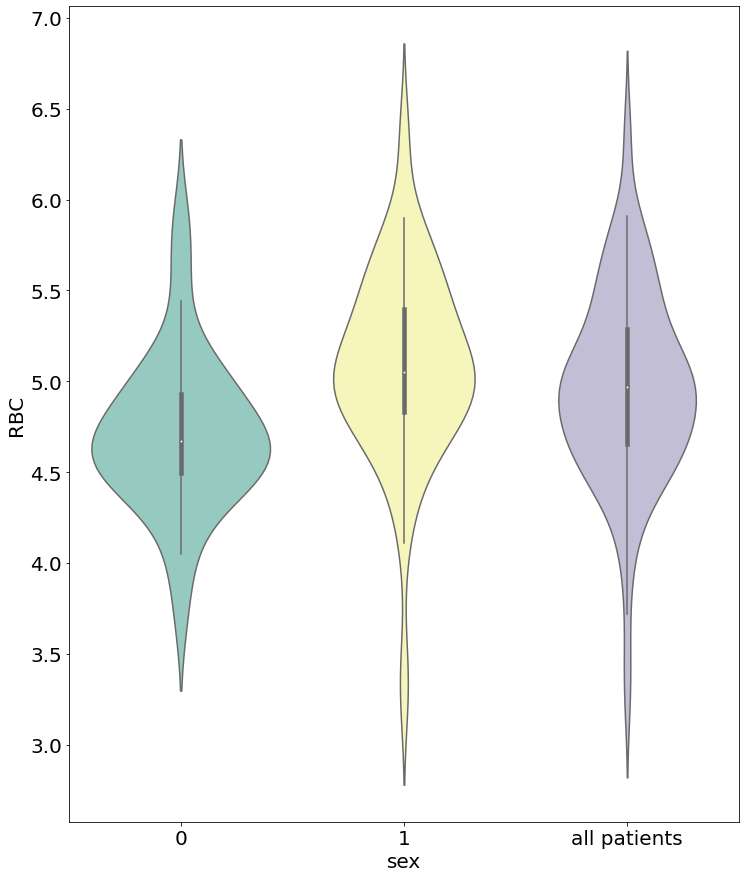

In [7]:
ddf = pd.DataFrame({'sex': 'all patients', 'RBC':df['RBC']})
ddf = pd.concat([df,ddf],ignore_index=True)

plt.figure(figsize=(12,15))
sns.violinplot(data=ddf, x='sex', y='RBC', palette="Set3", inner='box');
del ddf

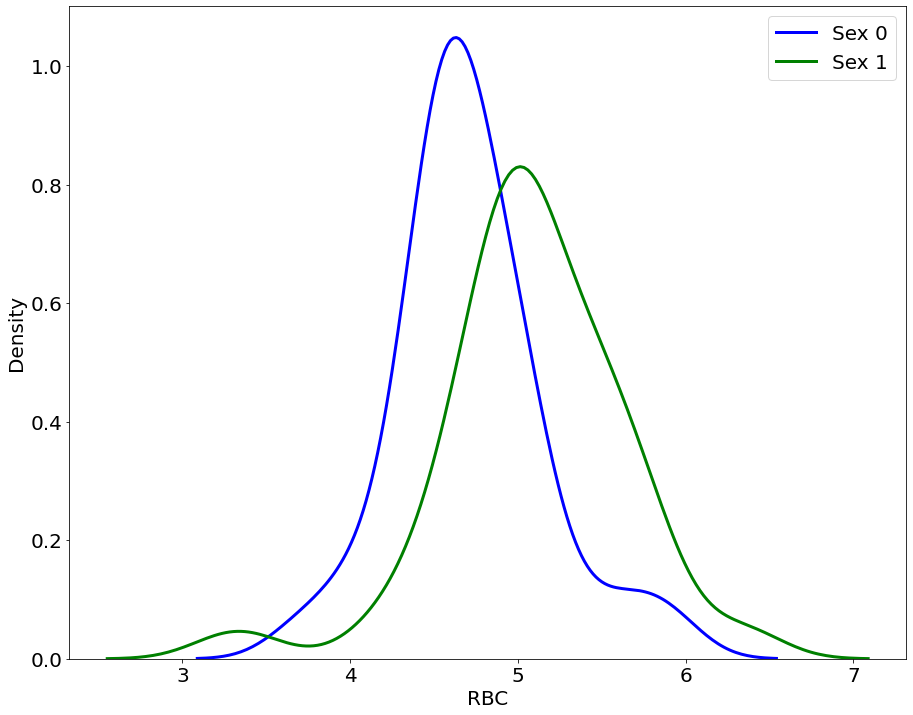

In [8]:
plt.figure(figsize=(15, 12))
sns.kdeplot(df[df['sex']==0]['RBC'], lw=3, label='Sex 0', color='blue')
sns.kdeplot(df[df['sex']==1]['RBC'], lw=3, label='Sex 1', color='green')
plt.legend()
plt.show()

In [9]:
df[df['sex']==0].shape

(35, 2)

In [10]:
df[df['sex']==1].shape

(69, 2)

We see that there are twice as many gender 1 patients as gender 0 patients, but overall sample sizes are acceptable. Let's check the normality of the samples using the Shapiro-Wilk test.

In [11]:
print('Sex 0', sps.shapiro(df[df['sex']==0]))
print('Sex 1', sps.shapiro(df[df['sex']==1]))

Sex 0 ShapiroResult(statistic=0.7108036279678345, pvalue=1.9096467462897948e-10)
Sex 1 ShapiroResult(statistic=0.7305982112884521, pvalue=1.3166113266630235e-14)


Thus, we reject normality. It is better not to use unstable methods here. We will use the Wilcoxon-Mann-Whitney test. Criteria applicability conditions:
* Each of the samples must contain at least 3 feature values. It is allowed that in one sample there are two values, but in the second there are at least five.
* The sample data should not contain matching values (all numbers are different) or there should be very few such matches (up to 10).

Both conditions are met.

In [12]:
print('two-sided:', sps.mannwhitneyu(df[df['sex']==0]['RBC'], df[df['sex']==1]['RBC'], alternative='two-sided'))
print('less:', sps.mannwhitneyu(df[df['sex']==0]['RBC'], df[df['sex']==1]['RBC'], alternative='less'))
print('greater:', sps.mannwhitneyu(df[df['sex']==0]['RBC'], df[df['sex']==1]['RBC'], alternative='greater'))

two-sided: MannwhitneyuResult(statistic=593.5, pvalue=2.4329029036899513e-05)
less: MannwhitneyuResult(statistic=593.5, pvalue=1.2164514518449756e-05)
greater: MannwhitneyuResult(statistic=593.5, pvalue=0.9999882014592729)


Let's calculate the implementation of the shift estimate associated with the Mann-Whitney statistics

In [13]:
data0 = df[df['sex']==0]['RBC'].to_numpy()
data1 = df[df['sex']==1]['RBC'].to_numpy()

W = np.array([[data1[j] - data0[i]   for i in np.arange(len(data0))] for j in np.arange(len(data1))]).flatten()
np.median(W)

0.3900000000000001

Also calculate the implementation of the confidence interval of the shift value

In [14]:
alpha = 0.05
z = sps.norm.ppf(1 - alpha)
n = len(data1)
m = len(data0)
k = int(np.floor(n*m/2 - 1/2 - z * np.sqrt(n*m*(n+m+1)/12)))
W = np.sort(W)

print('Confidence interval (alpha = 0.05):')
print('(',round(W[k], 3),',',round(W[n*m-k - 1], 3), ')')


Confidence interval (alpha = 0.05):
( 0.27 , 0.54 )


We see that the distributions are different. This also confirms the criterion, rejecting the main hypothesis in favor of alternatives. Multiple hypothesis testing should not be used, since the reliability of rejection is quite high.

### Part 2 : Age - TVA (tricuspid valve annulus (рус. ТК ФК)) 

In [15]:
columns = ['Возраст', 'ТКФК (см)']
df = data[columns].dropna()
df.shape

(94, 2)

In [16]:
df = df.rename(columns={'Возраст': 'age', 'ТКФК (см)': 'TVA'})
columns = ['age', 'TVA']
df.head()

,age,TVA
0,67.0,3.1
2,63.0,3.4
3,43.5,3.0
5,53.0,4.2
7,59.0,3.5


Let's look at the distributions

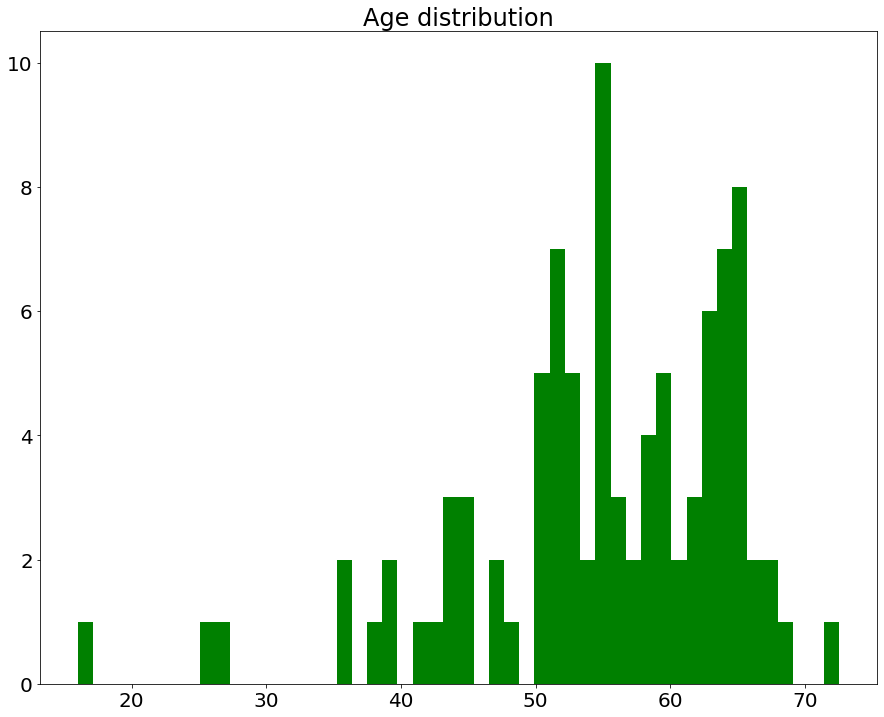

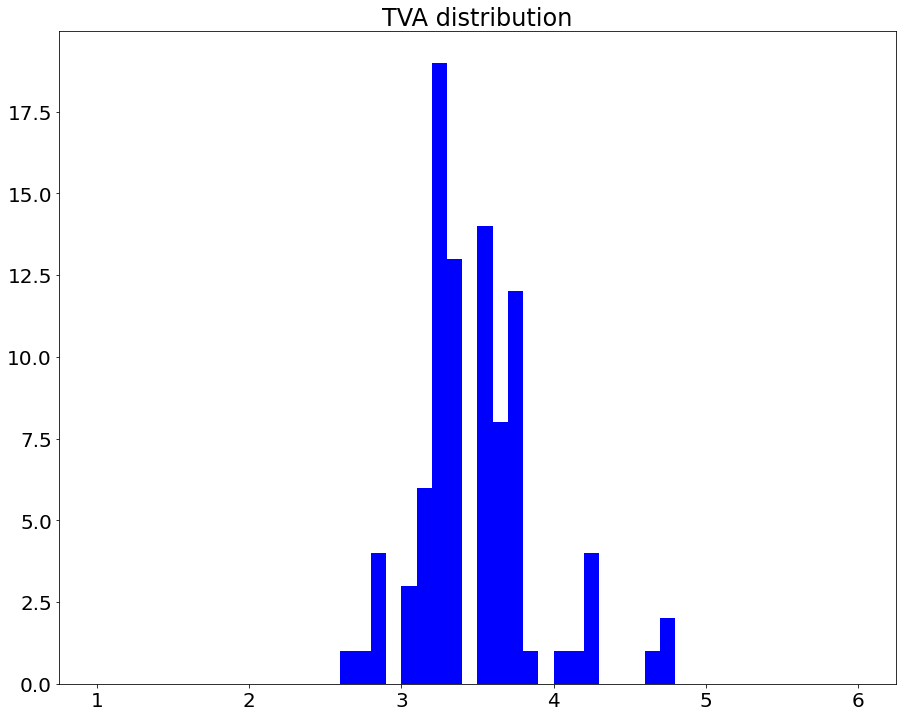

In [17]:
plt.figure(figsize=(15, 12))
plt.hist(df['age'], bins=50, label='Age', color='green')
plt.title('Age distribution');

plt.figure(figsize=(15, 12))
plt.hist(df['TVA'], bins=50, label='TVA', color='blue', range=[1,6])
plt.title('TVA distribution');

Also consider the distribution of patients in the feature space

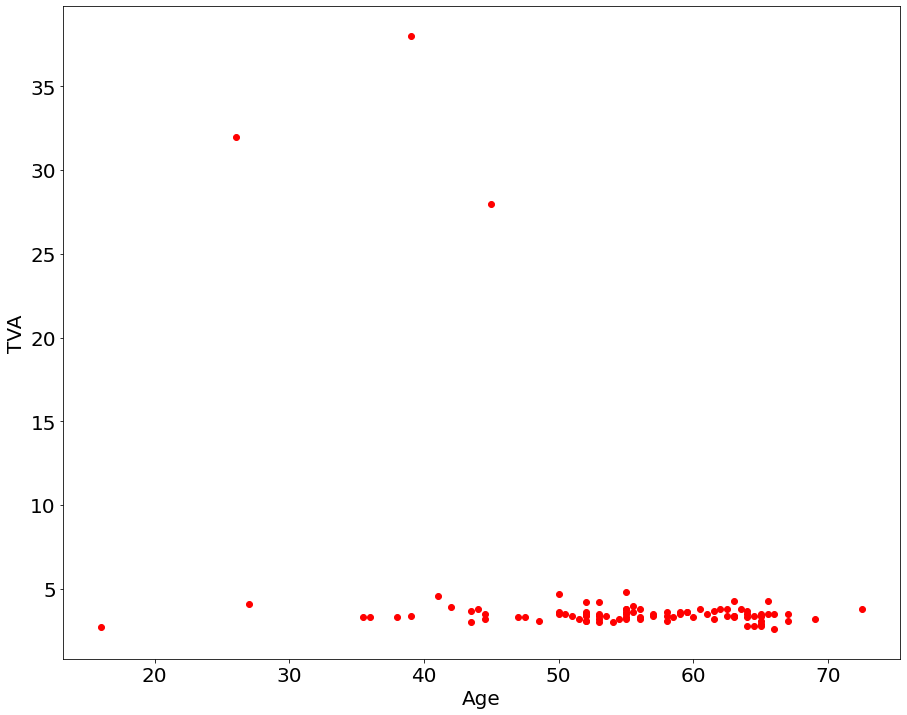

In [18]:
fig = plt.figure(figsize=(15, 12))

plt.plot(df['age'], df['TVA'], 'or')
plt.xlabel('Age')
plt.ylabel('TVA')
plt.show()

Get rid of data outliers

In [19]:
df = df[df['TVA'] < 20]
df.shape

(91, 2)

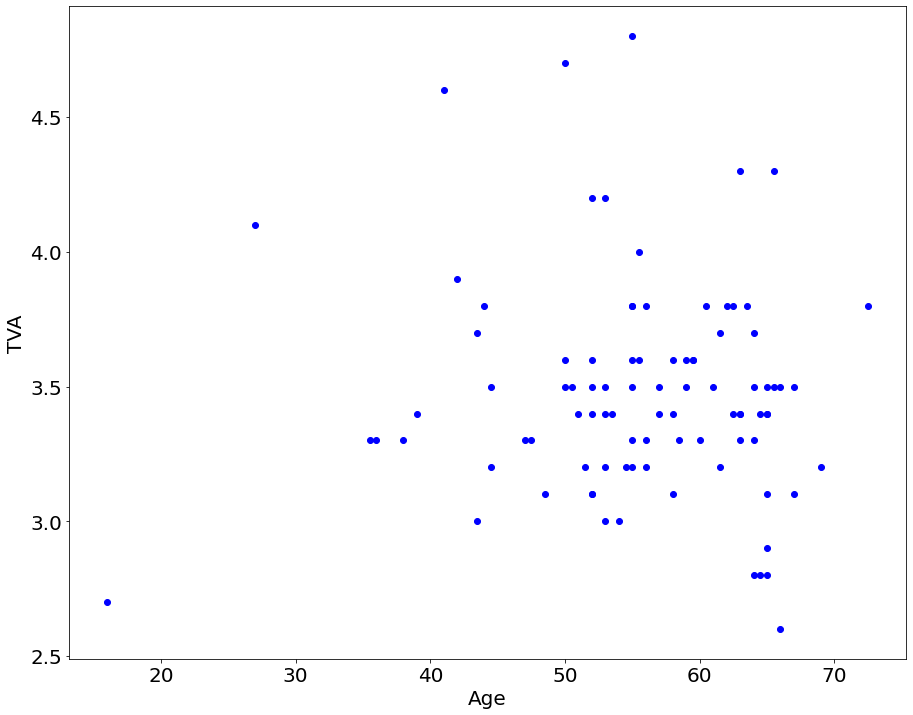

In [20]:
fig = plt.figure(figsize=(15, 12))

plt.plot(df['age'], df['TVA'], 'ob')
plt.xlabel('Age')
plt.ylabel('TVA');

The data looks uncorrelated, but for better verification, we calculate three correlation coefficients: Spearman, Pearson and Kendall:

In [21]:
print("Kendall:", sps.kendalltau(df.age, df.TVA))
print("Spearman:", sps.spearmanr(df.age, df.TVA))
print("Pearson:", sps.pearsonr(df.age, df.TVA))

Kendall: SignificanceResult(statistic=-0.029419229447547327, pvalue=0.6939043077712826)
Spearman: SignificanceResult(statistic=-0.04631974534257836, pvalue=0.6628453614100516)
Pearson: PearsonRResult(statistic=-0.04843514721300615, pvalue=0.6484457858015927)


And confidence interval using scipy pearsonr function:

In [22]:
pearson = stats.pearsonr(df.age, df.TVA)
pearson.confidence_interval()

ConfidenceInterval(low=-0.2518676236699798, high=0.15909668550477274)

Thus, after visual analysis and calculation of correlation coefficients, we can say with great confidence that there is no relationship between these two features. It should be noted that these correlation coefficients do not capture all dependencies, but here you can be sure just by looking at the graph.